In [ ]:

import polars as pl
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from extraction_functions import upsample_acc_df
from extraction_functions import find_sleep_period
import neurokit2 as nk
from hrvanalysis import get_time_domain_features
from hrvanalysis import get_frequency_domain_features
from hrvanalysis import get_poincare_plot_features
from hrvanalysis import remove_ectopic_beats, interpolate_nan_values

#set path to REMOTES folder
path = '../../../data'

# Load the data
df = pd.read_csv(f'{path}/sensor_data.csv')

#read in signal freq -> dictionary
file = open(f'{path}/label_freq.txt', 'r')
label_freq = file.read()
label_freq = eval(label_freq)
file.close()

ecg_fs = label_freq['ECG_A']
print(ecg_fs)


### Now Standard Features been collected, Short-Term HRV features can be collected usign the ECG data.
### To find the period of sleep between 3-7am with cleanest ECG, both the processed HR and biobank data is used.

In [ ]:
from hrvanalysis import get_time_domain_features
from hrvanalysis import get_frequency_domain_features
from hrvanalysis import get_poincare_plot_features
from hrvanalysis import remove_ectopic_beats, interpolate_nan_values

df['RMSSD'] = np.nan
df['SDNN'] = np.nan
df['pNN50'] = np.nan
df['MeanNN'] = np.nan
df['LF'] = np.nan
df['VLF'] = np.nan
df['HF'] = np.nan
df['LF_HF'] = np.nan
df['SD1'] = np.nan
df['SD2'] = np.nan

#iniialise lists to store patient IDs with over 50 ectopic beats
fifty_ect = []

print('starting_loop')
for index, row in df.iterrows():
    patient_id = row['Patient ID']
    print(f"Processing patient {patient_id}")
    file_name = row['file_name']
    start_time = row['Start']

    # Load HR file
    hr_values = np.load(f'{path}/hr_values/{patient_id}.npy')

    # Load and upsample activity data
    acc_df = pd.read_csv(f'{path}/activity_class/{patient_id}_combined-timeSeries.csv.gz', compression='gzip')
    acc_df = upsample_acc_df(acc_df)

    # Ensure HR values and acc_df are the same length
    if len(hr_values) > len(acc_df):
        hr_values = hr_values[:len(acc_df)]
    elif len(hr_values) < len(acc_df):
        hr_values = np.append(hr_values, [0] * (len(acc_df) - len(hr_values)))

    # Add HR values to acc_df
    acc_df['HR'] = hr_values

    # Find a continuous sleep period with minimum noisy HR data
    sleep_period = find_sleep_period(acc_df)

    # Process HRV if a sleep period is found 
    if sleep_period is not None:
        start, end = sleep_period
        hrv_df = acc_df.iloc[start:end]
        valid_hr_values = hrv_df['HR'][hrv_df['HR'] != 0]
        
        
        # Calculate how many seconds into the start of the ECG recording the sleep period starts
        time_len = start * 10
        ecg_df = pl.read_parquet(f'{path}/bdf_files/{file_name}/{patient_id}/ECG_A.parquet')
        ecg_10min = ecg_df.to_numpy().reshape(-1)[int(time_len * ecg_fs): int(time_len * ecg_fs) + int(900 * ecg_fs)]

        # Process ECG clean window
        ecg_clean = []
        noisy_segments = []
        time_index = 0

        #loop through the HR values and if clean ECG then append the ECG values, else keep track of the noisy segments
        for _, hr_row in hrv_df.iterrows():
            if hr_row['HR'] != 0:
                ecg_segment = ecg_10min[time_index:time_index + int(10 * ecg_fs)]
                ecg_clean.extend(ecg_segment)
            else:
                noisy_segments.append(time_index)
            time_index += int(10 * ecg_fs)
            if len(ecg_clean) >= int(5 * 60 * ecg_fs):
                break
        print(f"Noisy segments removed: {noisy_segments}")

        if noisy_segments == []:
            ecg_clean = ecg_clean[:int(5 * 60 * ecg_fs)]
            ecg_signals, info = nk.ecg_process(ecg_clean, sampling_rate=ecg_fs)
            #get the beat locations
            beat_locations = info['ECG_R_Peaks']
            #get the nn intervals and convert to ms
            nn_intervals = np.diff(beat_locations) / ecg_fs
            nn_intervals = [interval * 1000 for interval in nn_intervals]
            nn_intervals = remove_ectopic_beats(nn_intervals)

            #count number of ectopic beats and if over 50 then keep track of the patient ID
            if len(nn_intervals) > 0:
                ectopic_beats = np.isnan(nn_intervals).sum()
                    
                if ectopic_beats > 50:
                    fifty_ect.append(patient_id)

            #interpolate the nan values
            nn_intervals = interpolate_nan_values(nn_intervals)

            time_domain_features = get_time_domain_features(nn_intervals)
            frequency_domain_features = get_frequency_domain_features(nn_intervals, method='welch')
            nonlinear_domain_features = get_poincare_plot_features(nn_intervals)

            # Store HRV metrics directly in the DataFrame
            df.loc[index, 'RMSSD'] = time_domain_features['rmssd']
            print(f"Processed HRV for patient {patient_id}: RMSSD={time_domain_features['rmssd']}")
            df.loc[index, 'SDNN'] = time_domain_features['sdnn']
            print(f"Processed HRV for patient {patient_id}: SDNN={time_domain_features['sdnn']}")
            df.loc[index, 'pNN50'] = time_domain_features['pnni_50']
            print(f"Processed HRV for patient {patient_id}: pNN50={time_domain_features['pnni_50']}")
            df.loc[index, 'MeanNN'] = time_domain_features['mean_nni']
            print(f"Processed HRV for patient {patient_id}: MeanNN={time_domain_features['mean_nni']}")
            df.loc[index, 'LF'] = frequency_domain_features['lf']
            print(f"Processed HRV for patient {patient_id}: LF={frequency_domain_features['lf']}")
            df.loc[index, 'HF'] = frequency_domain_features['hf']
            print(f"Processed HRV for patient {patient_id}: HF={frequency_domain_features['hf']}")
            df.loc[index, 'VLF'] = frequency_domain_features['vlf']
            print(f"Processed HRV for patient {patient_id}: VLF={frequency_domain_features['vlf']}")
            df.loc[index, 'LF_HF'] = frequency_domain_features['lf_hf_ratio']
            print(f"Processed HRV for patient {patient_id}: lf_hf_ratio={frequency_domain_features['lf_hf_ratio']}")
            df.loc[index, 'SD1'] = nonlinear_domain_features['sd1']
            print(f"Processed HRV for patient {patient_id}: SD1={nonlinear_domain_features['sd1']}")
            df.loc[index, 'SD2'] = nonlinear_domain_features['sd2']
            print(f"Processed HRV for patient {patient_id}: SD2={nonlinear_domain_features['sd2']}")

        else:
            #if there are noisy segments, follow the protocol to remove the noisy segments
            ecg_clean = ecg_clean[:int(5 * 60 * ecg_fs)]
            ecg_signals, info = nk.ecg_process(ecg_clean, sampling_rate=ecg_fs)  # Re-process ECG signal
            beat_locations = info['ECG_R_Peaks']

            #find the beat locations and remove the intervals immediately following the noisy segments
            post_noisy_beats = [next((bl for bl in beat_locations if bl > ns), None) for ns in noisy_segments]
            post_noisy_beat_indices = [np.where(beat_locations == pnb)[0][0] for pnb in post_noisy_beats if pnb in beat_locations]

            # Calculate NN intervals and filter out intervals immediately following noisy segments
            nn_intervals = np.diff(beat_locations) / ecg_fs
            post_noisy_beat_indices_normal = [int(idx - 1) for idx in post_noisy_beat_indices]
            nn_intervals_clean = [nn_intervals[i] for i in range(len(nn_intervals)) if i not in post_noisy_beat_indices_normal]
            nn_intervals_clean = [interval * 1000 for interval in nn_intervals_clean]
            nn_intervals_clean = remove_ectopic_beats(nn_intervals_clean)

            #if over 50 beats are ectopic, add the patient ID to list
            if len(nn_intervals) > 0:
                ectopic_beats = np.isnan(nn_intervals).sum()    
                if ectopic_beats > 50:
                    fifty_ect.append(patient_id)

            #interpolate the nan values
            nn_intervals_clean = interpolate_nan_values(nn_intervals_clean)
            


            time_domain_features = get_time_domain_features(nn_intervals_clean)
            frequency_domain_features = get_frequency_domain_features(nn_intervals_clean, method='welch')
            nonlinear_domain_features = get_poincare_plot_features(nn_intervals_clean)

            # Store HRV metrics in the DataFrame
            df.loc[index, 'RMSSD'] = time_domain_features['rmssd']
            print(f"Processed HRV for patient {patient_id}: RMSSD={time_domain_features['rmssd']}")
            df.loc[index, 'SDNN'] = time_domain_features['sdnn']
            print(f"Processed HRV for patient {patient_id}: SDNN={time_domain_features['sdnn']}")
            df.loc[index, 'pNN50'] = time_domain_features['pnni_50']
            print(f"Processed HRV for patient {patient_id}: pNN50={time_domain_features['pnni_50']}")
            df.loc[index, 'MeanNN'] = time_domain_features['mean_nni']
            print(f"Processed HRV for patient {patient_id}: MeanNN={time_domain_features['mean_nni']}")
            df.loc[index, 'LF'] = frequency_domain_features['lf']
            print(f"Processed HRV for patient {patient_id}: LF={frequency_domain_features['lf']}")
            df.loc[index, 'HF'] = frequency_domain_features['hf']
            print(f"Processed HRV for patient {patient_id}: HF={frequency_domain_features['hf']}")
            df.loc[index, 'VLF'] = frequency_domain_features['vlf']
            print(f"Processed HRV for patient {patient_id}: VLF={frequency_domain_features['vlf']}")
            df.loc[index, 'LF_HF'] = frequency_domain_features['lf_hf_ratio']
            print(f"Processed HRV for patient {patient_id}: lf_hf_ratio={frequency_domain_features['lf_hf_ratio']}")
            df.loc[index, 'SD1'] = nonlinear_domain_features['sd1']
            print(f"Processed HRV for patient {patient_id}: SD1={nonlinear_domain_features['sd1']}")
            df.loc[index, 'SD2'] = nonlinear_domain_features['sd2']
            print(f"Processed HRV for patient {patient_id}: SD2={nonlinear_domain_features['sd2']}")
                                                                           
            


starting_loop
Processing patient R001
Number of rows with clean ECG: 89
Average HR in sleep period: 67.10112359550561
Noisy segments removed: []
2 ectopic beat(s) have been deleted with malik rule.
Processed HRV for patient R001: RMSSD=43.072290571910735
Processed HRV for patient R001: SDNN=74.68020724413472
Processed HRV for patient R001: pNN50=15.277777777777779
Processed HRV for patient R001: MeanNN=1034.5730657439447
Processed HRV for patient R001: LF=3055.83841252012
Processed HRV for patient R001: HF=369.5241809332159
Processed HRV for patient R001: VLF=1368.718102254694
Processed HRV for patient R001: lf_hf_ratio=8.269657495221947
Processed HRV for patient R001: SD1=30.508918068689816
Processed HRV for patient R001: SD2=101.11118942200115
Processing patient R002
Number of rows with clean ECG: 90
Average HR in sleep period: 84.13333333333334
Noisy segments removed: []
0 ectopic beat(s) have been deleted with malik rule.
Processed HRV for patient R002: RMSSD=16.06572946658528
Proc

/Users/aronsyversen/miniforge3/envs/hr-env/lib/python3.12/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


0 ectopic beat(s) have been deleted with malik rule.
Processed HRV for patient R072: RMSSD=3.5541345988977175
Processed HRV for patient R072: SDNN=4.939431146460261
Processed HRV for patient R072: pNN50=0.0
Processed HRV for patient R072: MeanNN=580.876427184466
Processed HRV for patient R072: LF=4.160961428363693
Processed HRV for patient R072: HF=1.6534453642258586
Processed HRV for patient R072: VLF=9.10566220900441
Processed HRV for patient R072: lf_hf_ratio=2.516540019035858
Processed HRV for patient R072: SD1=2.5155946269222333
Processed HRV for patient R072: SD2=6.516727996030173
Processing patient R073
Number of rows with clean ECG: 90
Average HR in sleep period: 63.86666666666667
Noisy segments removed: []
0 ectopic beat(s) have been deleted with malik rule.
Processed HRV for patient R073: RMSSD=26.196555628717878
Processed HRV for patient R073: SDNN=42.95824147822786
Processed HRV for patient R073: pNN50=4.25531914893617
Processed HRV for patient R073: MeanNN=1054.81407773851

In [ ]:
#save the dataframe
df.to_csv(f'{path}/sensor_data.csv', index=False)

### Save the patient ids with over 50 ectopic beats and add to the list of ID's to remove (if not already present)

In [ ]:
#open the file patients_to_remove2.txt and write the patient IDs with over 50 ectopic beats if not already present
file = open(f'{path}/patients_to_remove2.txt', 'r')
patients_to_remove = file.read()
patients_to_remove = patients_to_remove.split('\n')
file.close()

for patient in fifty_ect:
    if patient not in patients_to_remove:
        file = open(f'{path}/patients_to_remove2.txt', 'a')
        file.write(f"{patient}\n")
        file.close()



['R026', 'R044', 'R066', 'R114', 'R174', 'R175', 'R186', 'R195']
['R026', 'R066', 'R114', 'R174', 'R186']


### To check the identification of beats in the short-term HRV calculations we are going to plot the participants with the highest outliers:

In [ ]:


# List of features to check for the largest values
features = ['VLF', 'LF', 'HF', 'LF_HF', 'SD1', 'SD2', 'RMSSD', 'SDNN', 'pNN50', 'MeanNN']

# Initialize an empty list to store patient IDs with the largest values
highest_val = []

# Iterate through each feature and find the patient ID with the largest value
for feature in features:
    max_value = df_new[feature].max()
    patient_id = df_new[df_new[feature] == max_value]['Patient ID'].values[0]
    highest_val.append(patient_id)

#remove duplicates
highest_val = list(set(highest_val))
print(highest_val)




['R010', 'R010', 'R026', 'R111', 'R026', 'R010', 'R026', 'R010', 'R175', 'R068']
['R010', 'R068', 'R175', 'R026', 'R111']


Starting loop
Processing patient R010


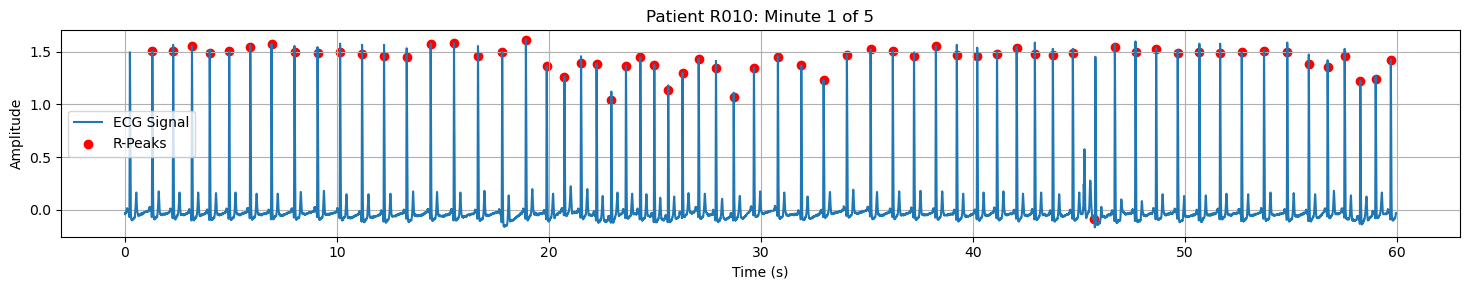

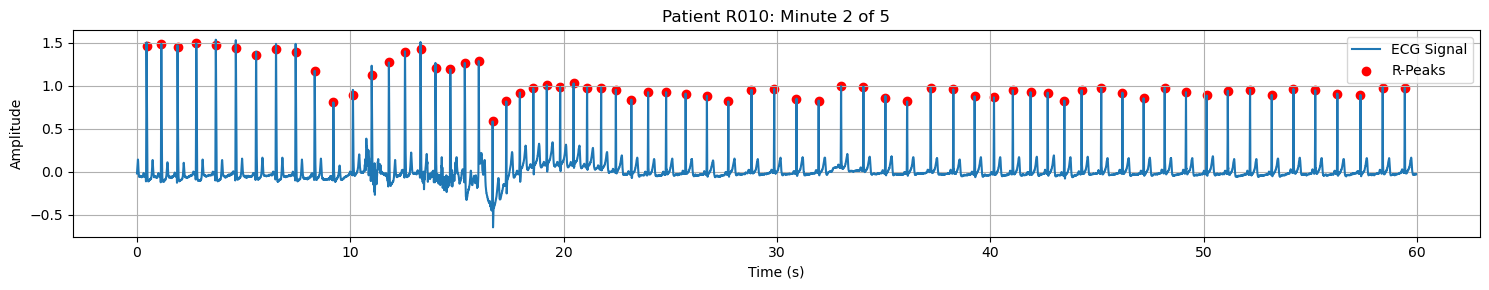

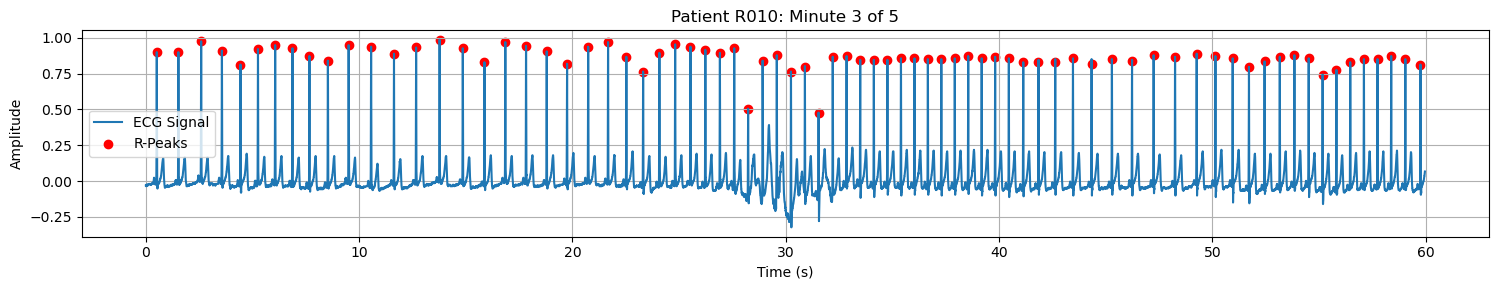

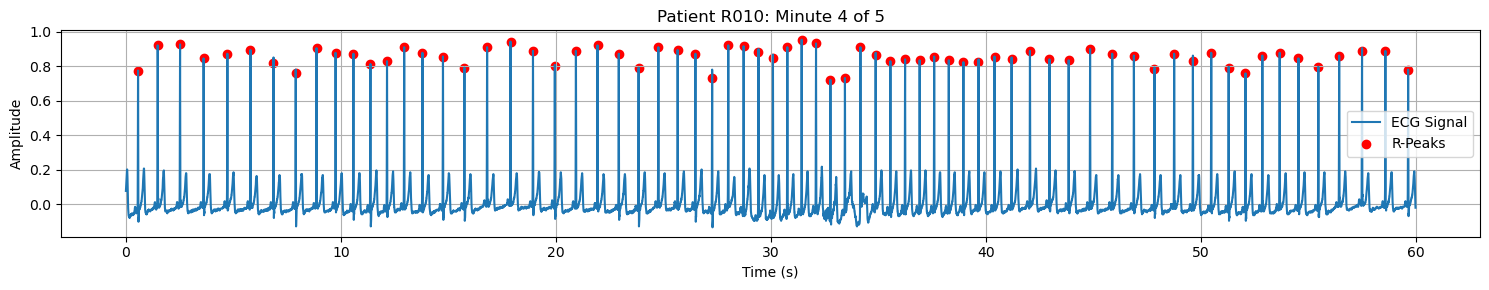

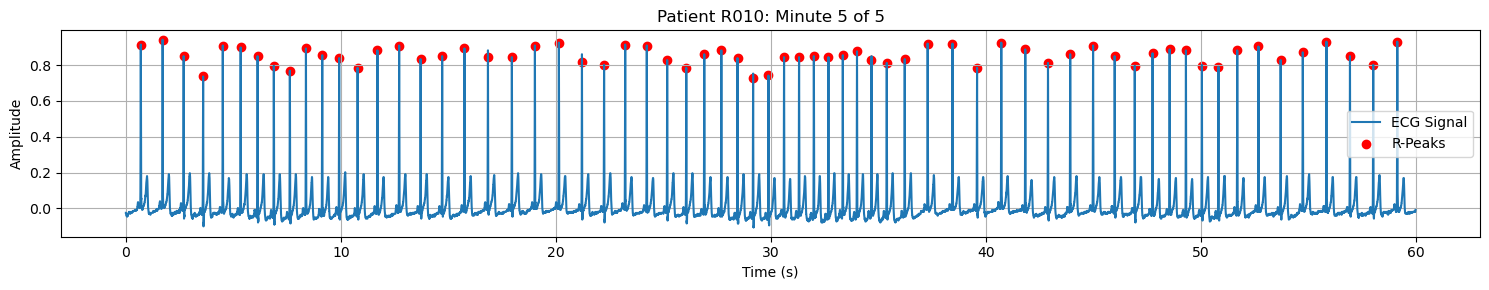

1 ectopic beat(s) have been deleted with malik rule.
HRV metrics processed for patient R010
Processing patient R026


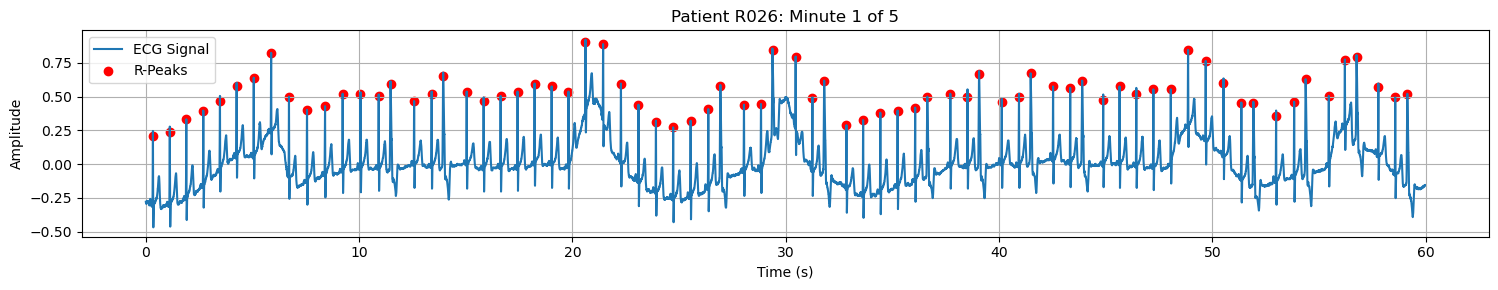

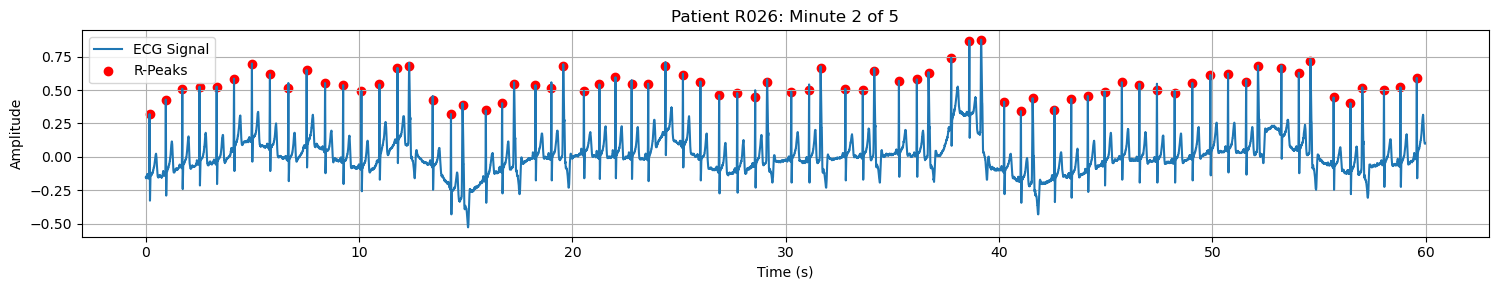

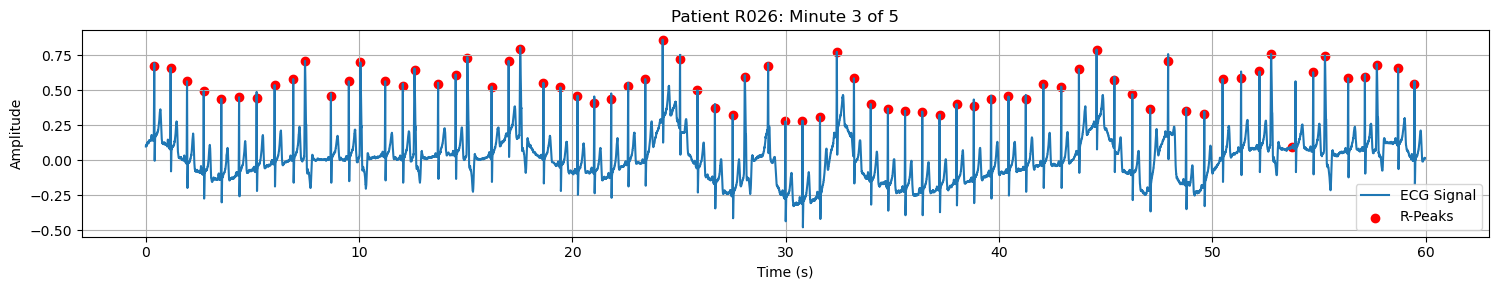

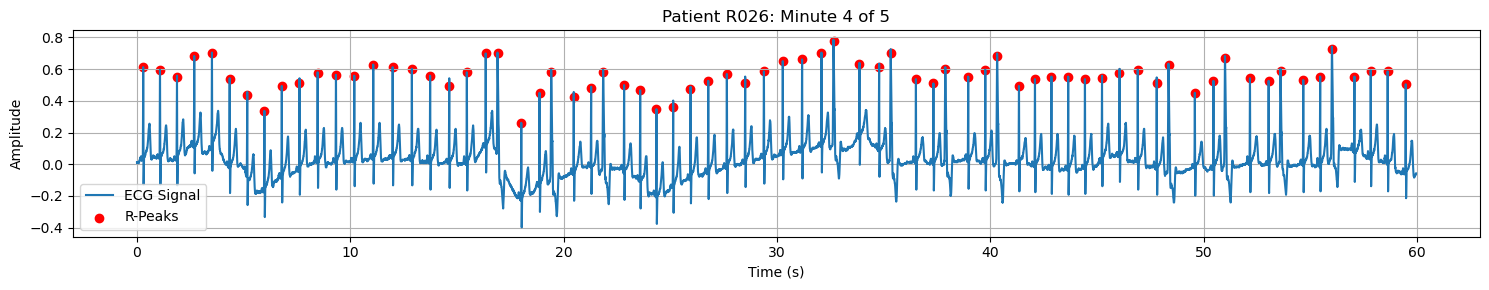

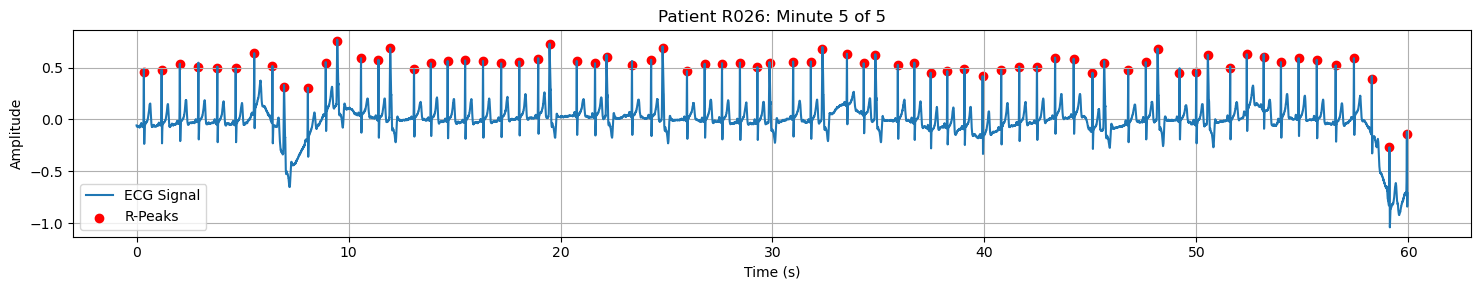

91 ectopic beat(s) have been deleted with malik rule.
HRV metrics processed for patient R026
Processing patient R068


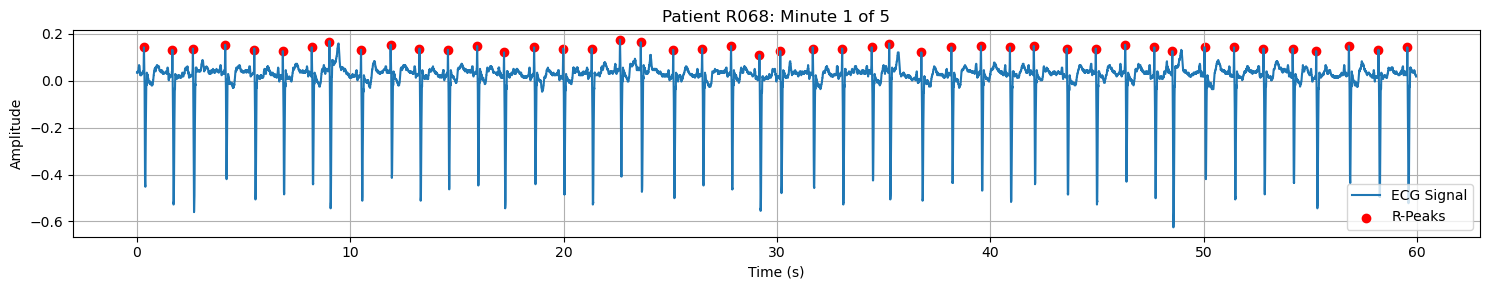

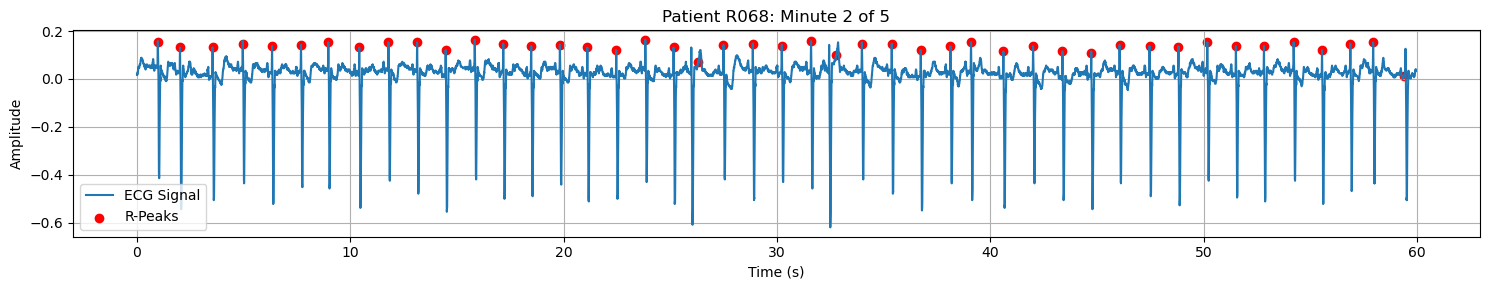

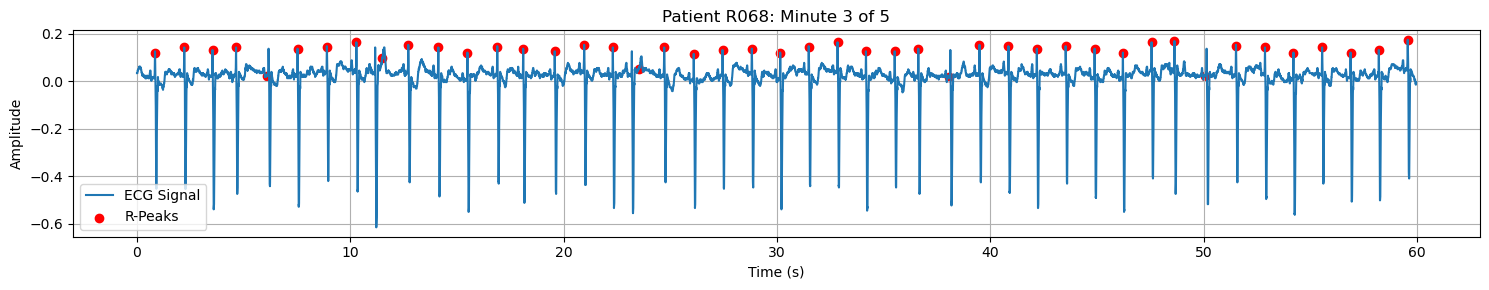

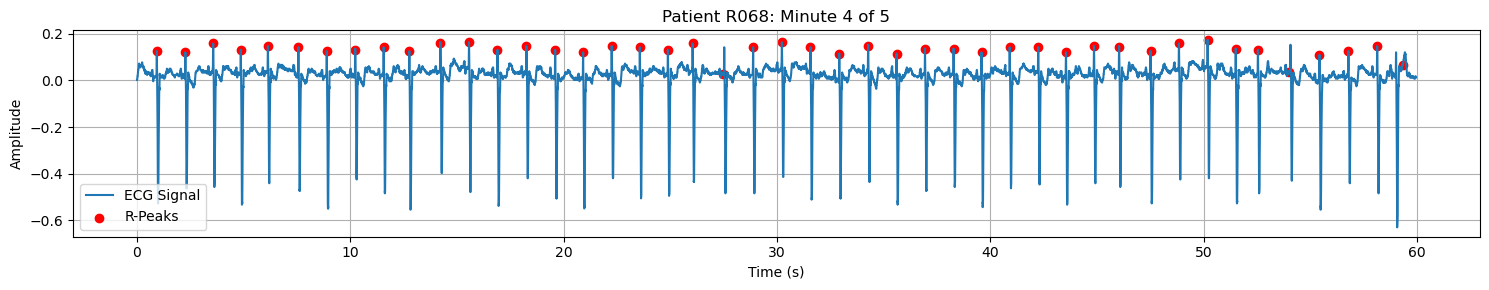

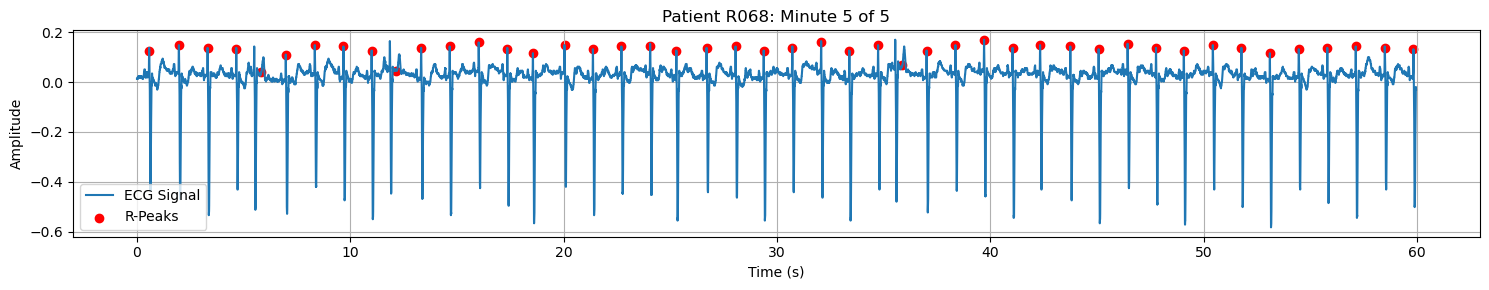

20 ectopic beat(s) have been deleted with malik rule.
HRV metrics processed for patient R068
Processing patient R111


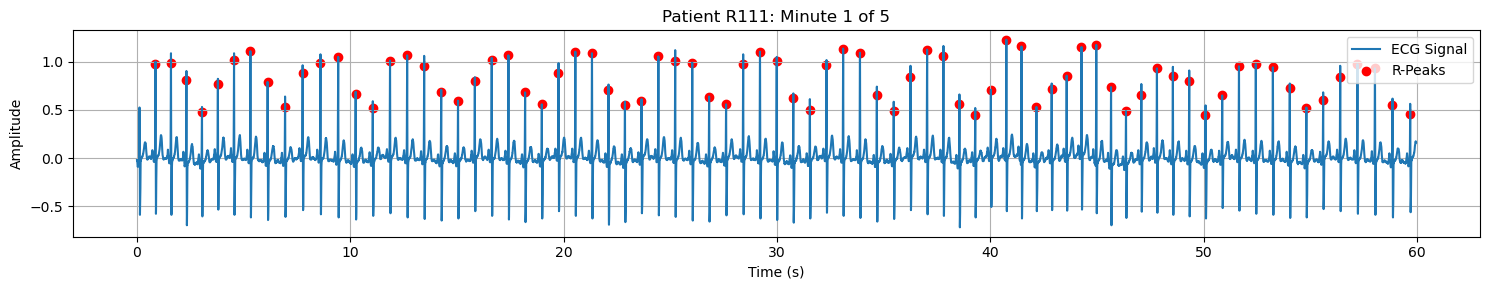

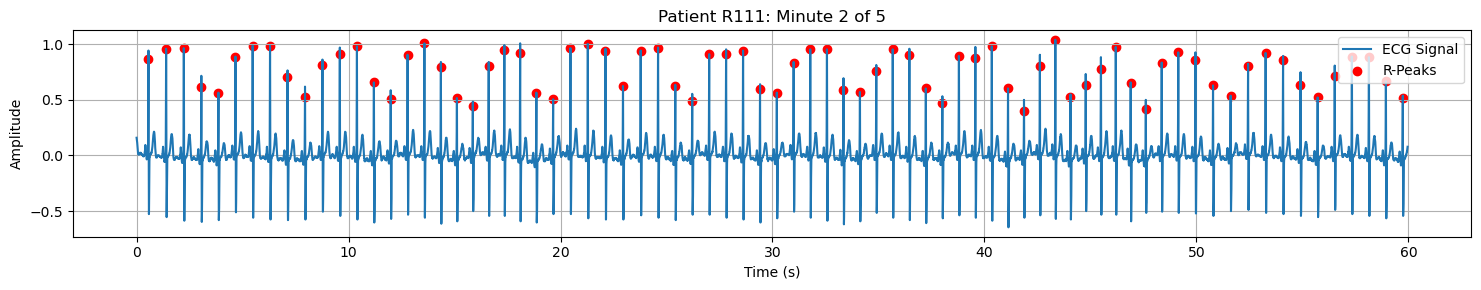

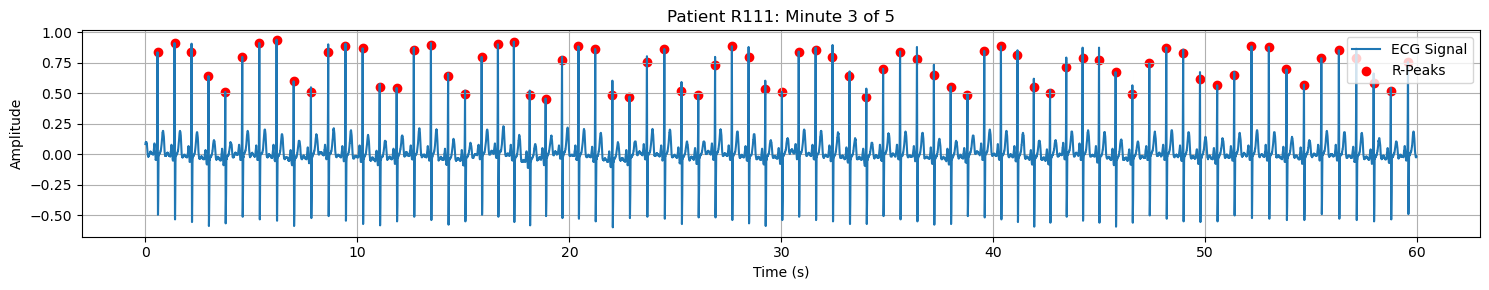

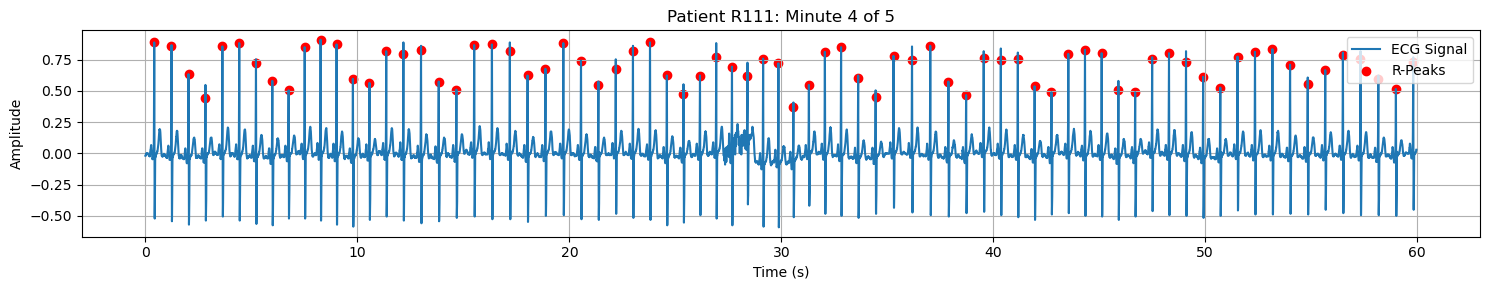

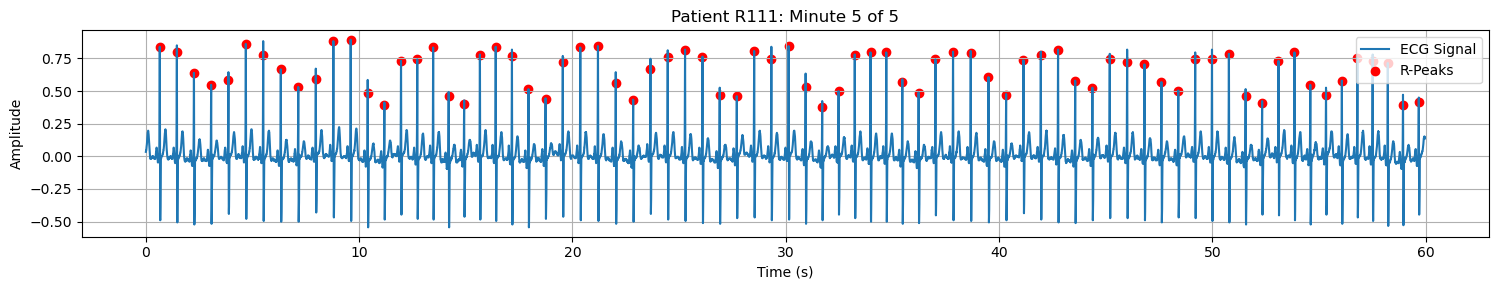

0 ectopic beat(s) have been deleted with malik rule.
HRV metrics processed for patient R111
Processing patient R175


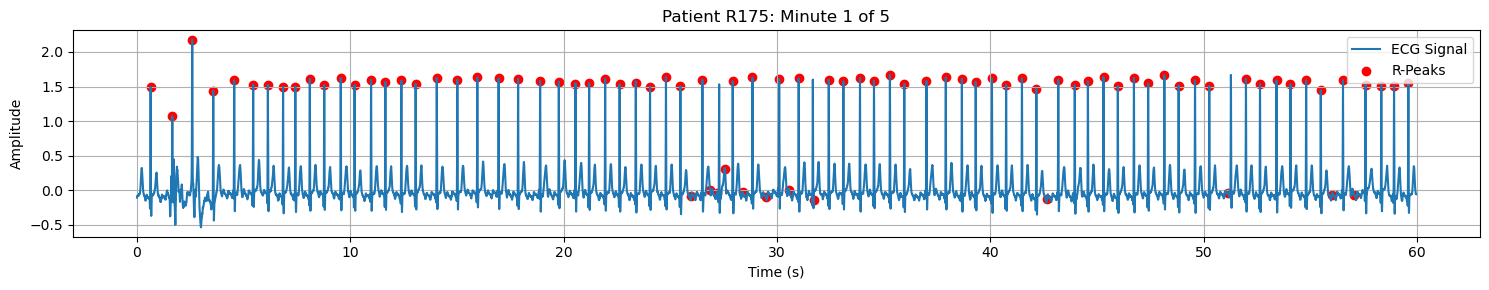

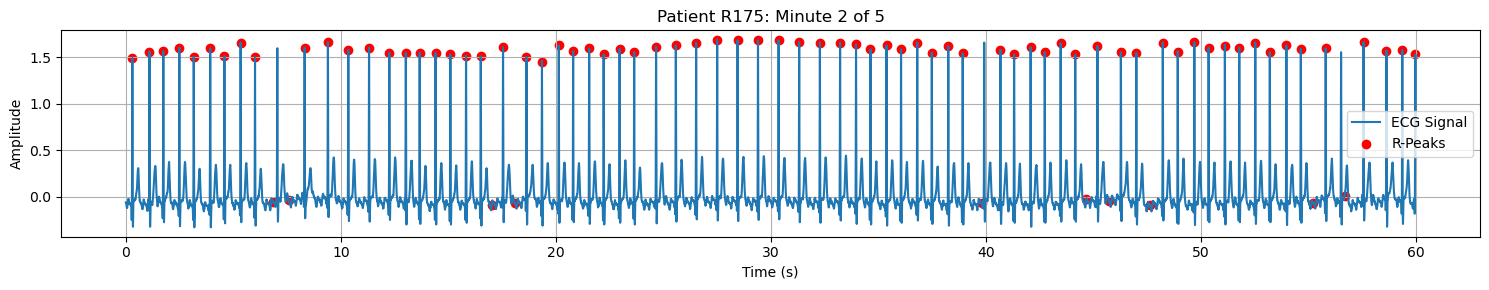

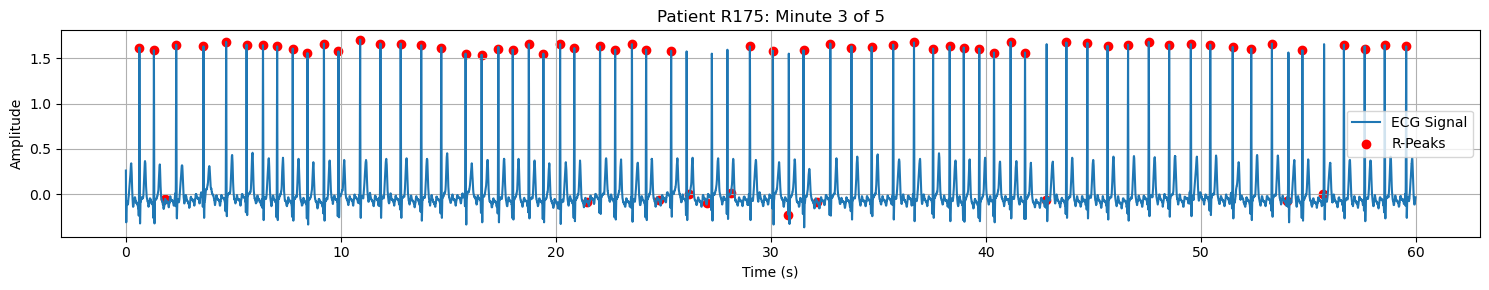

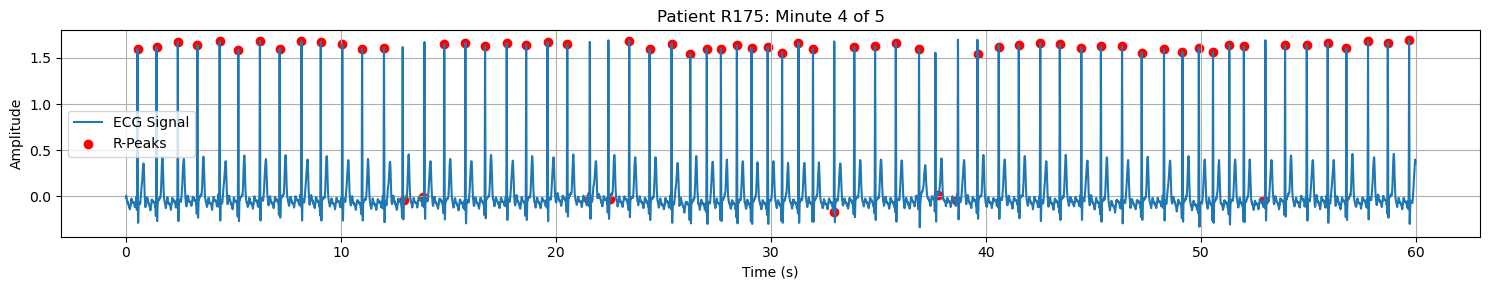

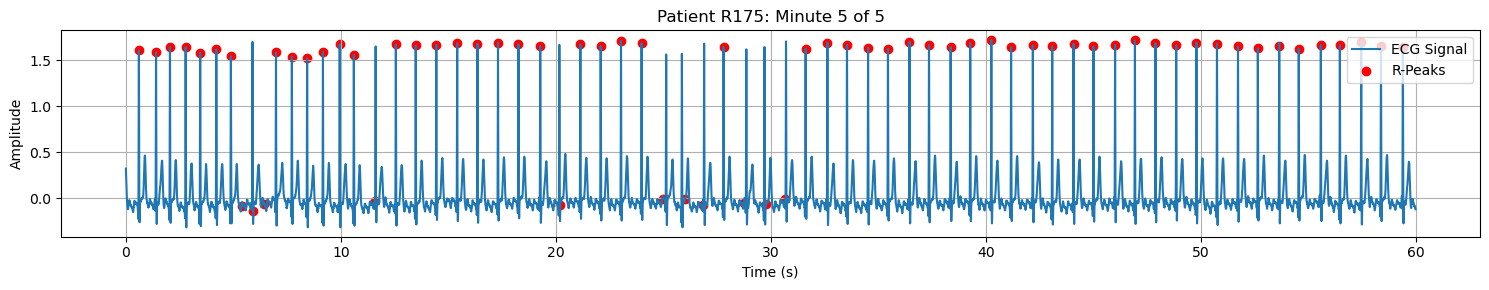

43 ectopic beat(s) have been deleted with malik rule.
HRV metrics processed for patient R175


In [20]:
#loop through the patients in the list highest_val and find their rows in the df

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import neurokit2 as nk
from hrvanalysis import (
    get_time_domain_features, get_frequency_domain_features, get_poincare_plot_features,
    remove_ectopic_beats, interpolate_nan_values
)

# List of Patient IDs to process
highest_val = ['R010', 'R068', 'R175', 'R026', 'R111']



print('Starting loop')
for index, row in df.iterrows():
    patient_id = row['Patient ID']
    if patient_id not in highest_val:
        continue  # Skip if Patient ID is not in the highest_val list

    print(f"Processing patient {patient_id}")
    file_name = row['file_name']
    start_time = row['Start']

    # Load HR file
    hr_values = np.load(f'{path}/hr_values/{patient_id}.npy')

    # Load and upsample activity data
    acc_df = pd.read_csv(f'{path}/activity_class/{patient_id}_combined-timeSeries.csv.gz', compression='gzip')
    acc_df = upsample_acc_df(acc_df)

    # Ensure HR values and acc_df are the same length
    if len(hr_values) > len(acc_df):
        hr_values = hr_values[:len(acc_df)]
    elif len(hr_values) < len(acc_df):
        hr_values = np.append(hr_values, [0] * (len(acc_df) - len(hr_values)))

    # Add HR values to acc_df
    acc_df['HR'] = hr_values

    # Find a continuous sleep period with minimum noisy HR data
    sleep_period = find_sleep_period(acc_df)
    if sleep_period is None:
        print(f"No clean sleep period found for patient {patient_id}")
        continue

    start, end = sleep_period
    hrv_df = acc_df.iloc[start:end]
    valid_hr_values = hrv_df['HR'][hrv_df['HR'] != 0]

    # Calculate time offset and extract 5-min ECG data
    time_len = start * 10
    ecg_df = pl.read_parquet(f'{path}/bdf_files/{file_name}/{patient_id}/ECG_A.parquet')
    ecg_5min = ecg_df.to_numpy().reshape(-1)[int(time_len * ecg_fs): int(time_len * ecg_fs) + int(300 * ecg_fs)]

    # Process ECG and detect R-peaks
    ecg_signals, info = nk.ecg_process(ecg_5min, sampling_rate=ecg_fs)
    beat_locations = info['ECG_R_Peaks']

    for i in range(5):
        start_idx = i * 60 * int(ecg_fs)  # Start of the minute
        end_idx = start_idx + 60 * int(ecg_fs)  # End of the minute
        ecg_1min = ecg_5min[start_idx:end_idx]
        beat_locations_1min = beat_locations[(beat_locations >= start_idx) & (beat_locations < end_idx)] - start_idx

        # Plot the one-minute segment
        fig, ax = plt.subplots(figsize=(15, 3))  # Narrower plot for one minute
        time_axis_1min = np.arange(len(ecg_1min)) / ecg_fs
        ax.plot(time_axis_1min, ecg_1min, label='ECG Signal')
        ax.scatter(beat_locations_1min / ecg_fs, ecg_1min[beat_locations_1min], color='red', label='R-Peaks')
        ax.set_title(f'Patient {patient_id}: Minute {i + 1} of 5')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

    # Calculate HRV metrics
    nn_intervals = np.diff(beat_locations) / ecg_fs * 1000  # Convert to ms
    nn_intervals = remove_ectopic_beats(nn_intervals)
    nn_intervals = interpolate_nan_values(nn_intervals)

    time_domain_features = get_time_domain_features(nn_intervals)
    frequency_domain_features = get_frequency_domain_features(nn_intervals, method='welch')
    nonlinear_domain_features = get_poincare_plot_features(nn_intervals)

    # Store HRV metrics in the DataFrame
    df.loc[index, 'RMSSD'] = time_domain_features['rmssd']
    df.loc[index, 'SDNN'] = time_domain_features['sdnn']
    df.loc[index, 'pNN50'] = time_domain_features['pnni_50']
    df.loc[index, 'MeanNN'] = time_domain_features['mean_nni']
    df.loc[index, 'LF'] = frequency_domain_features['lf']
    df.loc[index, 'HF'] = frequency_domain_features['hf']
    df.loc[index, 'LF_HF'] = frequency_domain_features['lf_hf_ratio']
    df.loc[index, 'SD1'] = nonlinear_domain_features['sd1']
    df.loc[index, 'SD2'] = nonlinear_domain_features['sd2']

    print(f"HRV metrics processed for patient {patient_id}")
